tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


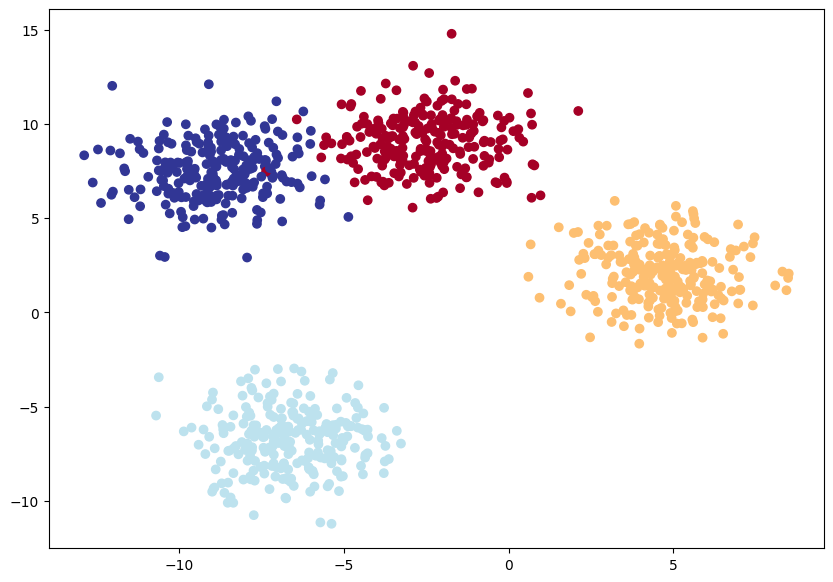

In [1]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [2]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"


# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [3]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

train loss 1.2487642765045166 test loss 0.44185569882392883
train loss 0.03463214263319969 test loss 0.02590975910425186
train loss 0.02989785186946392 test loss 0.020151743665337563
train loss 0.02845192886888981 test loss 0.01816367544233799
train loss 0.027688995003700256 test loss 0.017083119601011276
train loss 0.02716321498155594 test loss 0.0163586363196373
train loss 0.02674674801528454 test loss 0.015811018645763397
train loss 0.026391180232167244 test loss 0.015364893712103367
train loss 0.0260743610560894 test loss 0.01498333364725113
train loss 0.02578463777899742 test loss 0.014646094292402267


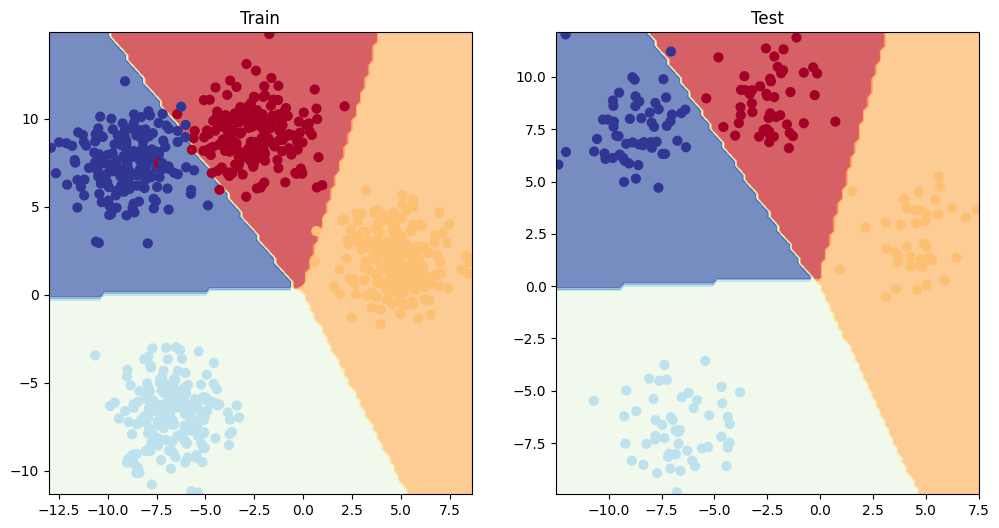

In [4]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)

epochs = 1000

for epoch in range(epochs):
  model_4.train()

  X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
  y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

  # 1 Forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels tüm classların problarını veriyor .argmax ile en yüksek ihtimali olanı alıyoruz

  # 2 Calculate the loss
  loss = loss_fn(y_logits, y_blob_train)

  # 3 optimizer zero grad
  optimizer.zero_grad()

  # 4 loss backward (backpropagation)
  loss.backward()

  optimizer.step()
  ### Testing
  model_4.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Calculate test loss and accuracy
    test_loss = loss_fn(test_logits, y_blob_test)

  if epoch % 100 == 0:
    print(f"train loss {loss} test loss {test_loss}")

# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)



plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)